In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from skorch.regressor import NeuralNetRegressor
from tabularasa.MixedNet import MixedNet
from tabularasa.OrthonormalCertificates import OrthonormalCertificates

In [2]:
df = pd.read_pickle('./examples/data/simple_train.pkl')

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [4]:
model = NeuralNetRegressor(MixedNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           module__non_monotonic_net=EmbeddingNet(),
                           module__dim_non_monotonic=16,
                           module__dim_monotonic=2,
                           module__layers=[128, 128, 32],
                           module__integration_steps=300)

In [5]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3152        0.2885  8.3587
      2        0.2904        0.2851  8.4735
      3        0.2857        0.2825  8.2779
      4        0.2814        0.2796  8.1608
      5        0.2776        0.2762  8.0133
      6        0.2712        0.2705  8.5038
      7        0.2614        0.2595  8.1155
      8        0.2462        0.2441  8.1344
      9        0.2241        0.2244  8.2210
     10        0.1970        0.2040  8.0652
     11        0.1707        0.1886  8.0592
     12        0.1575        0.2262  8.0251
     13        0.2025        0.1785  8.0444
     14        0.2879        0.2969  8.2808
     15        0.2707        0.2291  8.0786
     16        0.1913        0.2088  8.1636
     17        0.1740        0.1813  8.2784
     18        0.1558        0.1757  8.2269
     19        0.1439        0.1659  8.0885
     20        0.1340        0.1619  8.0113
     21        0.1246        0.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MixedNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
            (6): Linear(in_features=32, out_fea

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

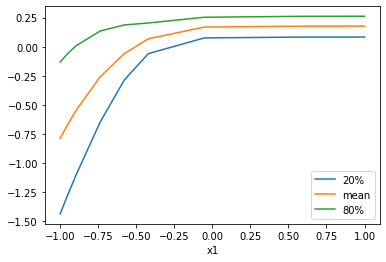

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

### Estimate epistemic uncertainty via orthonormal certificates

Start by prepping data from the inner hidden layer.

In [9]:
model.module_.set_last_layer(inner=True)

In [10]:
X_inner = model.predict({'X_monotonic': df[['x1', 'x2']].values,
                         'X_non_monotonic': df[['x3', 'x4']].values})

Now train orthonormal certificates.

In [13]:
oc = OrthonormalCertificates()
oc.fit(X_inner)

Create another PDP like dataset

In [14]:
uncertainties = []
for q in np.linspace(df['x1'].min(), df['x1'].max(), 50):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = oc.transform(model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                    'X_non_monotonic': dfc[['x3', 'x4']].values}))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

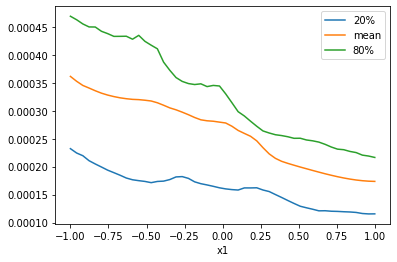

In [15]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

Hmmm... Not what I want.

# Scrap

In [16]:
x1 = np.linspace(-2, 2, num=101)
y = -x1 - x1 ** 2 + 2 * x1 ** 3
x2 = np.repeat(0, len(x1))
y += x2 * 0.2
x3 = np.repeat(0, len(x1))
y += (np.random.rand() / 3)
y *= (1 + np.random.normal() / 10)
y += np.random.normal(size=(len(x1))) / 10
x4 = np.repeat(0, len(x1))
dft = pd.DataFrame({'y': y.astype('float32'), 
                    'x1': x1.astype('float32'),
                    'x2': x2.astype('float32'),
                    'x3': x3.astype('int'), 
                    'x4': x4.astype('float32')})

In [17]:
u = oc.transform(model.predict({'X_monotonic': dft[['x1', 'x2']].values,
                                'X_non_monotonic': dft[['x3', 'x4']].values}))

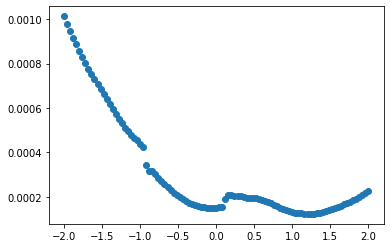

In [18]:
plt.scatter(x=dft['x1'], y=u)
plt.show()

This actually might be reasonable on the best case.

In [19]:
inner = model.predict({'X_monotonic': dft[['x1', 'x2']].values,
                       'X_non_monotonic': dft[['x3', 'x4']].values})

0


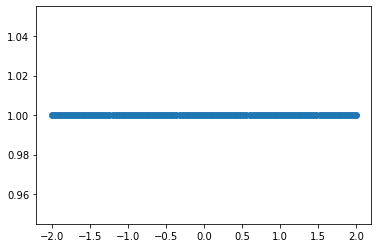

1


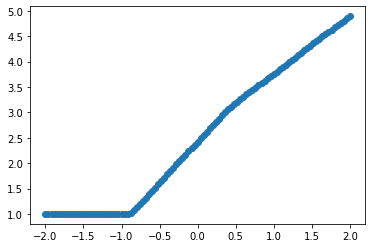

2


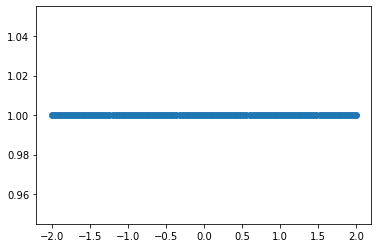

3


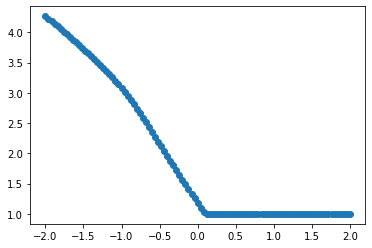

4


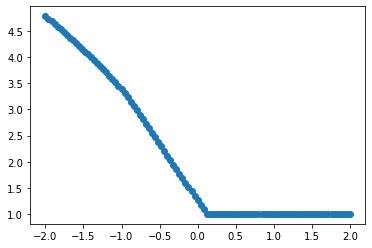

5


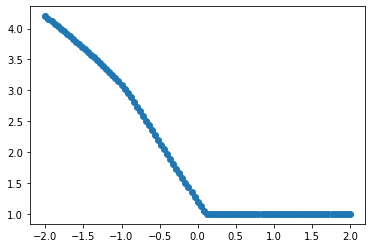

6


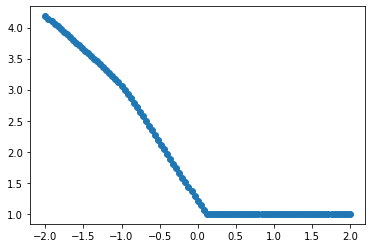

7


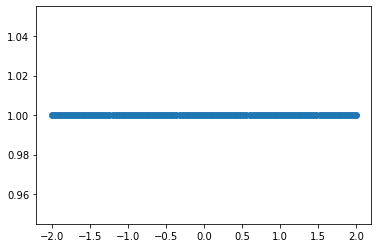

8


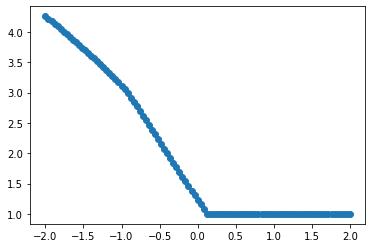

9


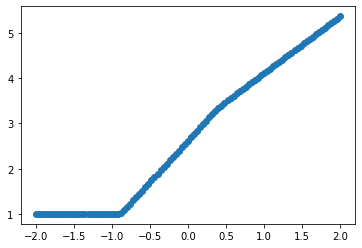

10


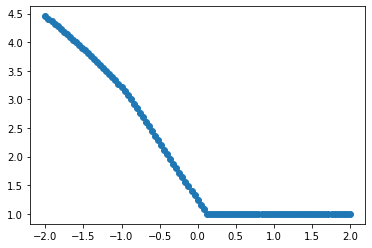

11


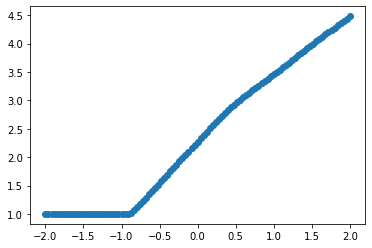

12


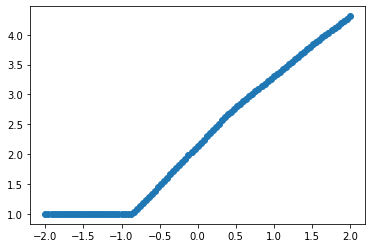

13


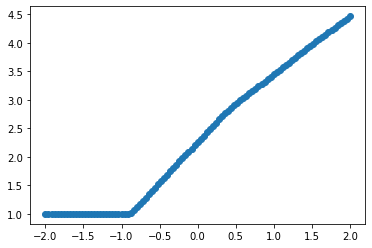

14


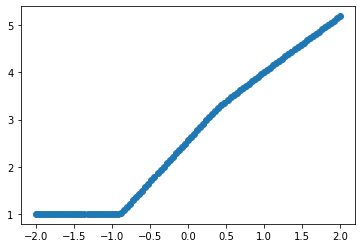

15


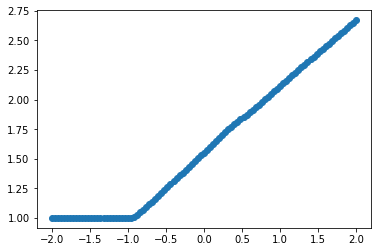

16


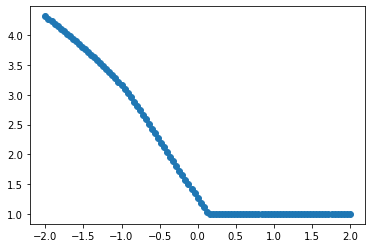

17


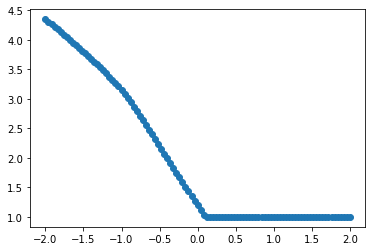

18


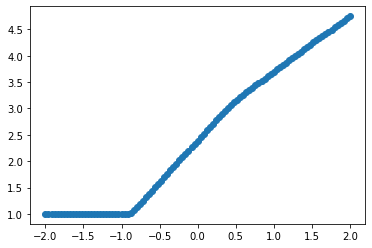

19


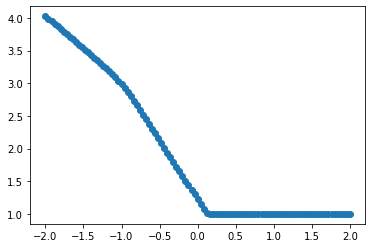

20


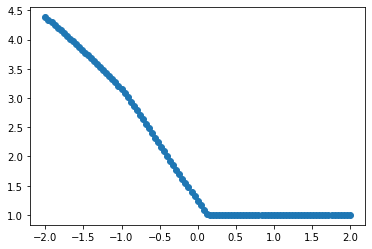

21


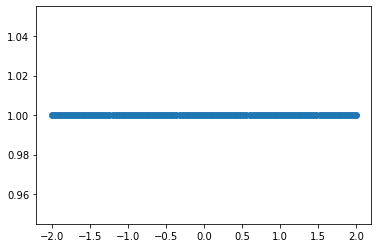

22


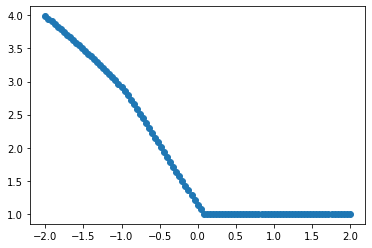

23


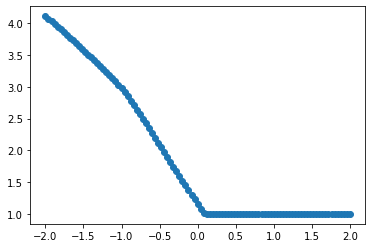

24


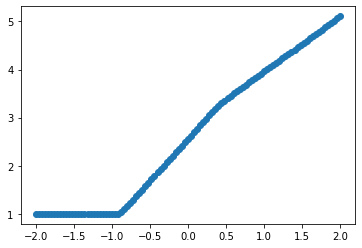

25


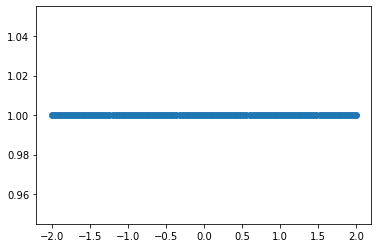

26


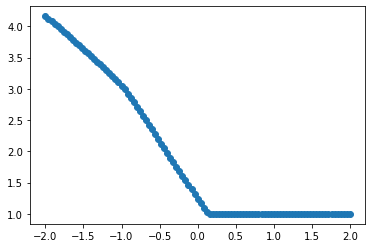

27


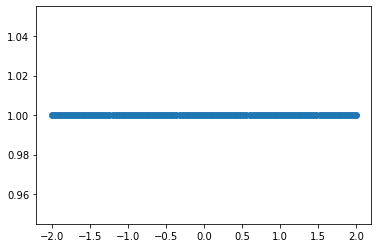

28


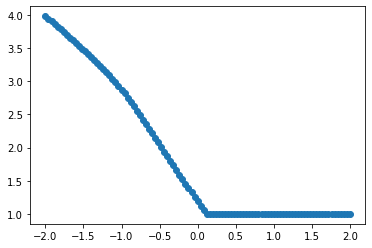

29


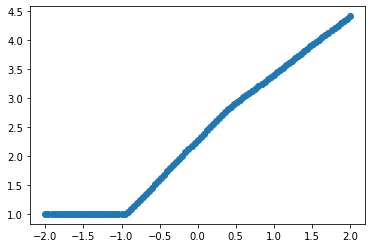

30


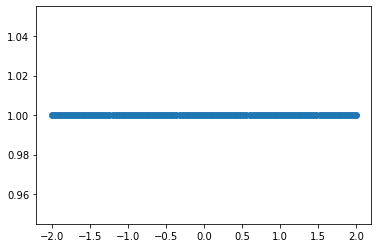

31


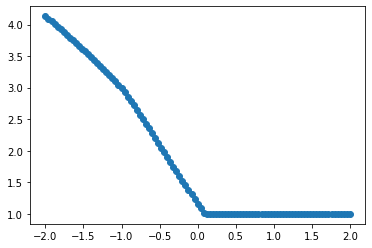

In [20]:
for i in range(inner.shape[1]):
    print(i)
    plt.scatter(x=dft['x1'], y=inner[:, i])
    plt.show()

This is still really weird.  Why are so many so similar?

What if I train orthonormal certificates on the original untransformed data and the transformed data... ?

In [21]:
ocr = OrthonormalCertificates()
ocr.fit(np.concatenate([df[['x1', 'x2', 'x3', 'x4']].values, X_inner], axis=1).astype('float32'))

In [23]:
uncertainties = []
for q in np.linspace(-2, 2, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = ocr.transform(np.concatenate([dfc[['x1', 'x2', 'x3', 'x4']].values,
                                      model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                                    'X_non_monotonic': dfc[['x3', 'x4']].values})], axis=1)
                                     .astype('float32'))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

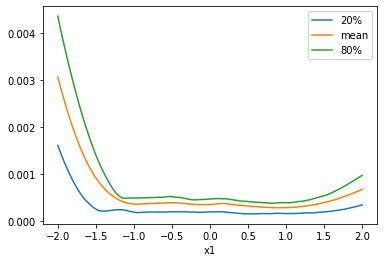

In [24]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

Maybe...  This is definitely better the the orthonormal certificates by themselves.

In [25]:
u = ocr.transform(np.concatenate([dft[['x1', 'x2', 'x3', 'x4']].values,
                                  model.predict({'X_monotonic': dft[['x1', 'x2']].values,
                                                 'X_non_monotonic': dft[['x3', 'x4']].values})], 1)
                  .astype('float32'))

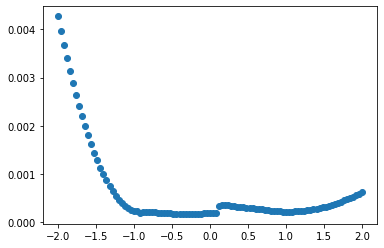

In [26]:
plt.scatter(x=dft['x1'], y=u)
plt.show()

Again, maybe not ideal in that it peaks way  more less than -1 than elsewhere, but it does at least bump between 0 and -0.5.

In [27]:
x1 = np.linspace(-2, 2, num=101)
y = -x1 - x1 ** 2 + 2 * x1 ** 3
x2 = x1 > 0 - (np.random.rand(len(x1)) > 0.8)
y += x2 * 0.2
x3 = np.repeat(0, len(x1))
y += (np.random.rand() / 3)
y *= (1 + np.random.normal() / 10)
y += np.random.normal(size=(len(x1))) / 10
x4 = np.random.normal(size=len(x1))
dft = pd.DataFrame({'y': y.astype('float32'), 
                    'x1': x1.astype('float32'),
                    'x2': x2.astype('float32'),
                    'x3': x3.astype('int'), 
                    'x4': x4.astype('float32')})

In [28]:
u = ocr.transform(np.concatenate([dft[['x1', 'x2', 'x3', 'x4']].values,
                                  model.predict({'X_monotonic': dft[['x1', 'x2']].values,
                                                 'X_non_monotonic': dft[['x3', 'x4']].values})], 1)
                  .astype('float32'))

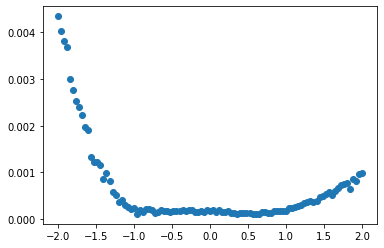

In [29]:
plt.scatter(x=dft['x1'], y=u)
plt.show()

Bump between 0 and 0.5 goes away a bit when we've got all the simulated in the best case.

Still need to think about this a bit.